[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

이제 우리는 몇 가지 사항에 대해 더 깊이 이해하게 되었습니다:

* 그래프 상태 스키마를 커스터마이징하는 방법
* 커스텀 상태 리듀서를 정의하는 방법
* 여러 그래프 상태 스키마를 사용하는 방법

## Goals

이제 LangGraph의 모델에 이러한 개념을 적용해 볼 수 있습니다!

앞으로 몇 차례에 걸쳐 장기 기억 기능을 갖춘 챗봇을 구축해 나가겠습니다.

챗봇이 메시지를 활용할 예정이니, 먼저 그래프 상태에서 메시지를 다루는 고급 기법에 대해 좀 더 살펴보겠습니다.

In [1]:
# %%capture --no-stderr
# %pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
# import os, getpass

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

from dotenv import load_dotenv

load_dotenv("../../.env")

True

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

We'll log to a project, `langchain-academy`. 

In [3]:
# _set_env("LANGSMITH_API_KEY")
# os.environ["LANGSMITH_TRACING"] = "true"
# os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"해양 포유류에 대해서 연구한다고 하셨나요?", name="Bot")]
messages.append(HumanMessage(f"네. 저는 고래에 대해서 잘 알아요. 그 외에 어떤 것을 공부해야 할까요?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

해양 포유류에 대해서 연구한다고 하셨나요?
================================ Human Message =================================
Name: Lance

네. 저는 고래에 대해서 잘 알아요. 그 외에 어떤 것을 공부해야 할까요?


이들을 채팅 모델에 전달할 수 있다는 점을 상기하십시오.

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='고래에 대해 이미 잘 알고 계시다면, 해양 포유류의 다른 그룹들을 공부하는 것도 매우 흥미로울 수 있습니다. 다음은 당신의 관심사를 확장하는 데 도움이 될 수 있는 몇 가지 주제입니다:\n\n1. **돌고래와 쇠돌고래**: 이들은 고래와 밀접한 관련이 있지만 행동, 사회 구조, 의사소통 방식에서 독특한 특성을 가지고 있습니다.\n\n2. **바다표범과 바다사자**: 이들 핀니펀(기각류) 포유류는 해양 환경에서의 적응과 육지 위 생활 사이에서의 균형을 연구하기에 흥미로운 주제입니다.\n\n3. **바다소와 듀공**: 초식성 해양 포유류로, 그들의 생태와 보존 문제는 연구할 가치가 있습니다.\n\n4. **해양 포유류의 진화와 생물지리학**: 해양 포유류가 어떻게 진화했으며, 다양한 해양 환경에서 어떻게 적응해 왔는지를 연구하는 것은 그들의 생태학적 적응을 이해하는 데 중요합니다.\n\n5. **보존 및 보호 노력**: 해양 포유류는 인간 활동과 환경 변화로 인해 다양한 위협에 직면해 있습니다. 보존 전략과 정책, 그리고 현장에서의 보호 활동에 대해 알아보는 것도 중요합니다.\n\n6. **해양 포유류의 생리학**: 이 동물들이 잠수, 수영, 체온 조절과 같은 해양 생활에 어떻게 적응했는지를 연구하는 것도 흥미로울 것입니다.\n\n이러한 주제들은 해양 포유류에 대한 이해의 폭을 넓히고, 이들을 보호하는 데 중요한 통찰을 제공할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 393, 'prompt_tokens': 49, 'total_tokens': 442, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0

우리는 `MessagesState`를 사용하여 간단한 그래프에서 채팅 모델을 실행할 수 있습니다.

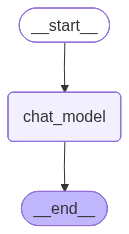

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

해양 포유류에 대해서 연구한다고 하셨나요?
================================ Human Message =================================
Name: Lance

네. 저는 고래에 대해서 잘 알아요. 그 외에 어떤 것을 공부해야 할까요?
================================== Ai Message ==================================

고래에 대한 연구를 이미 많이 하셨다면, 해양 포유류의 다른 그룹도 함께 공부해보시는 것이 좋겠습니다. 다음은 고려할 만한 해양 포유류의 주요 그룹입니다:

1. **물범과 바다사자 (Pinnipeds)**: 이 그룹에는 물범(seals), 바다사자(sea lions), 그리고 바다코끼리(walruses)가 포함됩니다. 이들은 지상과 물속 생활을 번갈아 하며, 다양한 생태적 적응을 지니고 있습니다.

2. **바다소류 (Sirenians)**: 듀공과 매너티로 대표되는 이 그룹은 초식성 동물로, 수중 생태계에서 중요한 역할을 합니다.

3. **해달 (Sea Otters)**: 해달은 해양 생태계에서 중요한 포식자로, 특히 해초숲의 건강에 많은 영향을 미칩니다.

4. **극지방의 해양 포유류**: 북극곰과 같은 동물은 극지방에 서식하며, 해양 생태계와 기후 변화 연구에서 중요한 위치를 차지하고 있습니다.

이 외에도 특정 종의 행동, 생태적 역할, 보존 상태 등의 주제를 심화 연구할 수 있습니다. 또한 해양 오염, 기후 변화가 해양 포유류에 미치는 영향에 대한 연구도 중요하며, 이를 통해 해양 생물 보존과 관련된 노력을 지원할 수 있습니다.


## Reducer

메시지를 다룰 때 실질적인 과제는 장시간 지속되는 대화 관리입니다.

장시간 지속되는 대화는 모델에 전달되는 메시지 목록이 계속 증가하기 때문에 주의하지 않으면 높은 토큰 사용량과 지연 시간을 초래합니다.

이를 해결할 수 있는 몇 가지 방법이 있습니다.

첫째, `RemoveMessage`와 `add_messages` 리듀서를 사용한 기법을 떠올려 보세요.

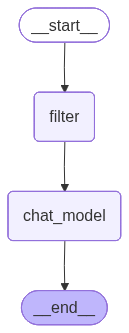

In [8]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # 최근 두개 메시지를 제외하고 모두 삭제
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("안녕하세요.", name="Bot", id="1")]
messages.append(HumanMessage("안녕하세요.", name="Lance", id="2"))
messages.append(AIMessage("해양 포유류에 대해서 연구한다고 하셨나요?", name="Bot", id="3"))
messages.append(HumanMessage("네. 저는 고래에 대해서 잘 알아요. 그 외에 어떤 것을 공부해야 할까요?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

해양 포유류에 대해서 연구한다고 하셨나요?
================================ Human Message =================================
Name: Lance

네. 저는 고래에 대해서 잘 알아요. 그 외에 어떤 것을 공부해야 할까요?
================================== Ai Message ==================================

고래에 대해 잘 알고 계시다면, 다음과 같은 관련 주제들도 흥미롭게 연구할 수 있을 것입니다:

1. **플랑크톤과 해양 먹이망**: 고래는 플랑크톤과 같은 작은 해양 생물을 먹이로 삼는 경우가 많습니다. 그래서 해양 생태계의 기본인 플랑크톤과 먹이망에 대해 배우는 것이 유익할 것입니다.

2. **음향 생리학**: 고래는 복잡한 소리를 통해 의사소통하고, 먹이를 찾고, 길을 찾습니다. 고래의 음향 생리학과 그들이 소리로 서로 어떻게 상호작용하는지에 대해 탐구해 보는 것도 좋습니다.

3. **보존 생물학**: 많은 고래 종이 멸종 위기에 처해 있습니다. 고래와 다른 해양 포유류를 보존하기 위해 어떤 정책과 전략이 필요한지 연구해 볼 수 있습니다.

4. **기후 변화의 영향**: 기후 변화가 고래와 해양 생태계 전반에 미치는 영향을 분석해 보세요. 해수 온도 상승, 산성화, 플랑크톤 분포 변화 등이 중요합니다.

5. **고래 연구 방법론**: 고래를 연구하기 위해 사용하는 다양한 방법론에 대해 배워 보세요. 예를 들어, 위성 추적, 드론 활용, 수중 청음기 등을 사용한 연구가 있습니다.

6. **고래의 사회 구조**: 고래의 사회적 행동 및 구조에 대해 연구하는 것도 흥미롭습니다. 특히, 범고래와 같은 독특한 사회 구조를 가진 고래 종이 있습니다.

이 외에도 해양 포

## Filtering messages

그래프 상태를 수정할 필요가 없거나 원하지 않는다면, 채팅 모델에 전달하는 메시지를 필터링하기만 하면 됩니다.

예를 들어, 필터링된 목록만 전달하세요: `llm.invoke(messages[-1:])`를 모델에 전달합니다.

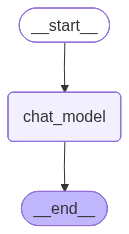

In [10]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

기존 메시지 목록에 위의 LLM 응답을 추가하고, 후속 질문을 추가합시다.

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"일각고래에 대해 더 알려주세요!", name="Lance"))

In [12]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

안녕하세요.
================================ Human Message =================================
Name: Lance

안녕하세요.
================================== Ai Message ==================================
Name: Bot

해양 포유류에 대해서 연구한다고 하셨나요?
================================ Human Message =================================
Name: Lance

네. 저는 고래에 대해서 잘 알아요. 그 외에 어떤 것을 공부해야 할까요?
================================== Ai Message ==================================

고래에 대해 잘 알고 계시다면, 다음과 같은 관련 주제들도 흥미롭게 연구할 수 있을 것입니다:

1. **플랑크톤과 해양 먹이망**: 고래는 플랑크톤과 같은 작은 해양 생물을 먹이로 삼는 경우가 많습니다. 그래서 해양 생태계의 기본인 플랑크톤과 먹이망에 대해 배우는 것이 유익할 것입니다.

2. **음향 생리학**: 고래는 복잡한 소리를 통해 의사소통하고, 먹이를 찾고, 길을 찾습니다. 고래의 음향 생리학과 그들이 소리로 서로 어떻게 상호작용하는지에 대해 탐구해 보는 것도 좋습니다.

3. **보존 생물학**: 많은 고래 종이 멸종 위기에 처해 있습니다. 고래와 다른 해양 포유류를 보존하기 위해 어떤 정책과 전략이 필요한지 연구해 볼 수 있습니다.

4. **기후 변화의 영향**: 기후 변화가 고래와 해양 생태계 전반에 미치는 영향을 분석해 보세요. 해수 온도 상승, 산성화, 플랑크톤 분포 변화 등이 중요합니다.

5. *

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

안녕하세요.
================================ Human Message =================================
Name: Lance

안녕하세요.
================================== Ai Message ==================================
Name: Bot

해양 포유류에 대해서 연구한다고 하셨나요?
================================ Human Message =================================
Name: Lance

네. 저는 고래에 대해서 잘 알아요. 그 외에 어떤 것을 공부해야 할까요?
================================== Ai Message ==================================

고래에 대해 잘 알고 계시다면, 다음과 같은 관련 주제들도 흥미롭게 연구할 수 있을 것입니다:

1. **플랑크톤과 해양 먹이망**: 고래는 플랑크톤과 같은 작은 해양 생물을 먹이로 삼는 경우가 많습니다. 그래서 해양 생태계의 기본인 플랑크톤과 먹이망에 대해 배우는 것이 유익할 것입니다.

2. **음향 생리학**: 고래는 복잡한 소리를 통해 의사소통하고, 먹이를 찾고, 길을 찾습니다. 고래의 음향 생리학과 그들이 소리로 서로 어떻게 상호작용하는지에 대해 탐구해 보는 것도 좋습니다.

3. **보존 생물학**: 많은 고래 종이 멸종 위기에 처해 있습니다. 고래와 다른 해양 포유류를 보존하기 위해 어떤 정책과 전략이 필요한지 연구해 볼 수 있습니다.

4. **기후 변화의 영향**: 기후 변화가 고래와 해양 생태계 전반에 미치는 영향을 분석해 보세요. 해수 온도 상승, 산성화, 플랑크톤 분포 변화 등이 중요합니다.

5. *

STATE는 모든 메시지를 보유하고 있습니다.

그러나 LangSmith 추적을 살펴보면 모델 호출이 마지막 메시지만 사용함을 확인할 수 있습니다:(이방법이 좋은듯)

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

또 다른 접근 방식은 [메시지 트리밍](https://docs.langchain.com/oss/python/langgraph/add-memory#trim-messages)으로, 정해진 토큰 수를 기준으로 합니다.

이는 메시지 기록을 지정된 토큰 수로 제한합니다.

필터링은 에이전트 간 메시지의 사후 하위 집합만 반환하는 반면, 트리밍은 챗 모델이 응답에 사용할 수 있는 토큰 수를 제한합니다.

아래의 `trim_messages`를 참조하십시오.

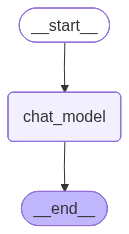

In [14]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"오카스가 어디에 사는지 말해줘요!", name="Lance"))

In [16]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='오카스가 어디에 사는지 말해줘요!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [17]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

In [18]:
for m in messages_out_trim['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

안녕하세요.
================================ Human Message =================================
Name: Lance

안녕하세요.
================================== Ai Message ==================================
Name: Bot

해양 포유류에 대해서 연구한다고 하셨나요?
================================ Human Message =================================
Name: Lance

네. 저는 고래에 대해서 잘 알아요. 그 외에 어떤 것을 공부해야 할까요?
================================== Ai Message ==================================

고래에 대해 잘 알고 계시다면, 다음과 같은 관련 주제들도 흥미롭게 연구할 수 있을 것입니다:

1. **플랑크톤과 해양 먹이망**: 고래는 플랑크톤과 같은 작은 해양 생물을 먹이로 삼는 경우가 많습니다. 그래서 해양 생태계의 기본인 플랑크톤과 먹이망에 대해 배우는 것이 유익할 것입니다.

2. **음향 생리학**: 고래는 복잡한 소리를 통해 의사소통하고, 먹이를 찾고, 길을 찾습니다. 고래의 음향 생리학과 그들이 소리로 서로 어떻게 상호작용하는지에 대해 탐구해 보는 것도 좋습니다.

3. **보존 생물학**: 많은 고래 종이 멸종 위기에 처해 있습니다. 고래와 다른 해양 포유류를 보존하기 위해 어떤 정책과 전략이 필요한지 연구해 볼 수 있습니다.

4. **기후 변화의 영향**: 기후 변화가 고래와 해양 생태계 전반에 미치는 영향을 분석해 보세요. 해수 온도 상승, 산성화, 플랑크톤 분포 변화 등이 중요합니다.

5. *

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r